In [1]:
import pandas as pd
import re
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

engine = create_engine('sqlite:///:memory:', echo=False)
df = pd.read_csv(r'C:\Users\nnnn7\Documents\Data Analyst certificate\Most Streamed Spotify Songs 2024.csv',encoding='unicode_escape')

# For answering the queries we need to convert some of the columns from object type to int/float. 
# We will be doing the conversion using regular expressions
def clean_spotify_streams(column):
    if isinstance(column, str):
        column = re.sub(r'[^\d]', '', column)
    return pd.to_numeric(column, errors='coerce')

# Apply the function to clean the desired columns we will be using in the queries
columns_to_convert = ["Spotify Streams", "Spotify Playlist Reach", "YouTube Views", 
                      "AirPlay Spins", "SiriusXM Spins", "Pandora Streams", 
                      "Soundcloud Streams", "Shazam Counts", "TikTok Posts", "TikTok Views"]
df[columns_to_convert] = df[columns_to_convert].applymap(clean_spotify_streams)

df = df.dropna(subset=columns_to_convert)

df.to_sql('spotify_songs', con=engine, index=False, if_exists='replace')

# In current project we won't be using all of the columns in the database, so we will delete the excess columns to save space.
query_create = '''
CREATE TABLE spotify_songs_new AS 
SELECT Track,"Album Name", Artist, "Release Date",
"Spotify Streams", "Spotify Playlist Reach", "Spotify Popularity",
"YouTube Views","TikTok Posts","TikTok Views","AirPlay Spins",
"SiriusXM Spins","Pandora Streams","Soundcloud Streams","Shazam Counts" 
FROM spotify_songs
'''
engine.execute(query_create)

query_drop_old = 'DROP TABLE spotify_songs'
engine.execute(query_drop_old)

query_rename_new = 'ALTER TABLE spotify_songs_new RENAME TO spotify_songs'
engine.execute(query_rename_new)


df_updated = pd.read_sql('spotify_songs', con=engine)

# Question 1: Print the first 5 rows to check the data
print(df_updated.head())
print(df_updated.dtypes)

                        Track                    Album Name          Artist  \
0         MILLION DOLLAR BABY  Million Dollar Baby - Single   Tommy Richman   
1                 Not Like Us                   Not Like Us  Kendrick Lamar   
2  i like the way you kiss me    I like the way you kiss me         Artemas   
3                 Lovin On Me                   Lovin On Me     Jack Harlow   
4  BAND4BAND (feat. Lil Baby)    BAND4BAND (feat. Lil Baby)     Central Cee   

  Release Date  Spotify Streams  Spotify Playlist Reach  Spotify Popularity  \
0    4/26/2024        390470936             196631588.0                92.0   
1   05/04/2024        323703884             174597137.0                92.0   
2    3/19/2024        601309283             211607669.0                92.0   
3   11/10/2023        670665438             175421034.0                83.0   
4    5/23/2024         90676573             184199419.0                86.0   

   YouTube Views  TikTok Posts  TikTok Views  AirP

In [2]:
# Question 2: Name the top 15 titles based on spotify streams

query = 'SELECT Track,Artist,"Spotify Streams" FROM spotify_songs ORDER BY "Spotify Streams" DESC LIMIT 15  '
df1 = pd.read_sql(query, con=engine)

#query = 'SELECT Track,Artist,"Spotify Streams" FROM spotify_songs ORDER BY "Spotify Streams" DESC LIMIT 50  '
#df1 = pd.read_sql(query, con=engine)
#query = 'SELECT Track,Artist,"Spotify Streams" FROM spotify_songs ORDER BY "Spotify Streams" DESC LIMIT 100 '
#df1 = pd.read_sql(query, con=engine)
# The above queries are used in question 10
print(df1)

                      Track           Artist  Spotify Streams
0           Blinding Lights       The Weeknd       4281468720
1              Shape of You       Ed Sheeran       3909458734
2                   Starboy       The Weeknd       3291262413
3              Dance Monkey      Tones And I       3071214106
4                  Believer  Imagine Dragons       3006226762
5              Lucid Dreams       Juice WRLD       2548389305
6                Photograph       Ed Sheeran       2525355904
7                   Shallow        Lady Gaga       2447973078
8                 The Hills       The Weeknd       2306740926
9                    Demons  Imagine Dragons       2270796677
10                     SAD!     XXXTENTACION       2218531106
11             Cruel Summer     Taylor Swift       2188247133
12         The Night We Met       Lord Huron       2097181065
13                    Sorry    Justin Bieber       2089476497
14  Smells Like Teen Spirit          Nirvana       2021910364


In [3]:
# Question 3: Is there a correlation between Spotify Playlist Reach and Spotify streams
#Playlist Reach is the total number of followers of all playlists that feature a song from that artist. 
#So for example if an artist was added to 10 playlists and each playlist had 100,000 followers then the total playlist reach would be 1 million.
query = 'SELECT Track ,"Spotify Streams", "Spotify Playlist Reach" FROM spotify_songs ORDER BY "Spotify Playlist Reach" DESC LIMIT 20'
result = pd.read_sql(query, con=engine)

print(result)

# It looks like there is no strong connection between the Playlist Reach and the Spotify Streams

                                             Track  Spotify Streams  \
0                                         Espresso        547882871   
1                                  I'm Good (Blue)       1658229422   
2                       i like the way you kiss me        601309283   
3                               BIRDS OF A FEATHER        214237645   
4                                     Cruel Summer       2188247133   
5                                            LUNCH        221636195   
6                              MILLION DOLLAR BABY        390470936   
7                       BAND4BAND (feat. Lil Baby)         90676573   
8                    Fortnight (feat. Post Malone)        395433400   
9                                      Lovin On Me        670665438   
10                                     Not Like Us        323703884   
11                                    Stick Season        965865213   
12                                          Austin        273023490   
13    

In [4]:
# Question 4: Who are the top 10 artists with the most songs in the Database? 
query = 'SELECT Artist, COUNT(*) As "Number of Songs", SUM("Spotify Streams") AS "Total Streams" FROM spotify_songs GROUP BY "Artist" ORDER BY "Number of Songs" DESC LIMIT 10'
result = pd.read_sql(query, con=engine)

print(result)

          Artist  Number of Songs  Total Streams
0          Drake               16     7943927023
1  Morgan Wallen               13     5351536971
2  Billie Eilish               11     6089028623
3     The Weeknd               10    18841056275
4   Taylor Swift               10     9567910070
5            SZA                8     6273245361
6     Zach Bryan                7     2753205209
7      Bad Bunny                7     4815926651
8    Post Malone                6     5014069280
9       Rod Wave                5      445112859


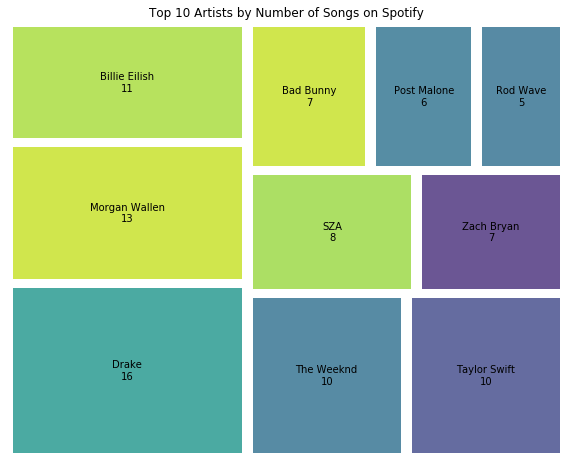

In [5]:
import squarify
query = 'SELECT Artist, COUNT(*) As "Number of Songs", SUM("Spotify Streams") AS "Total Streams" FROM spotify_songs GROUP BY "Artist" ORDER BY "Number of Songs" DESC LIMIT 10'
result = pd.read_sql(query, con=engine)

fig, ax = plt.subplots(figsize=(10,8))

sizes = result['Number of Songs']
labels = result['Artist'] + '\n' + (result['Number of Songs']).astype(str) 

squarify.plot(sizes=sizes, label=labels, alpha=.8, ax=ax, pad = 0.25)
plt.title('Top 10 Artists by Number of Songs on Spotify')
plt.axis('off')  # Turn off the axis
plt.show()

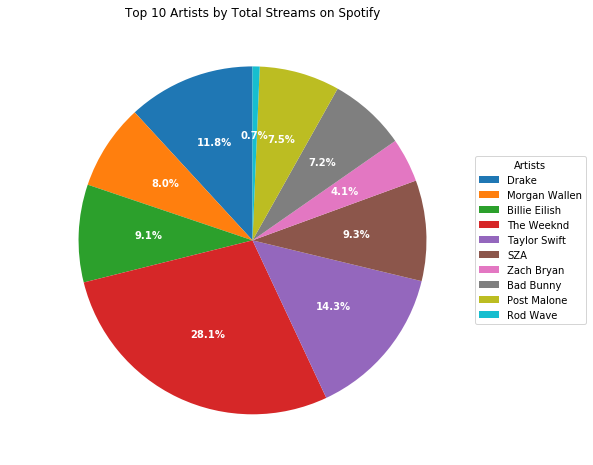

In [6]:
# For a nice addition, I also added a pie chart with top 10 artists by Total Streams
query = 'SELECT Artist, COUNT(*) As "Number of Songs", SUM("Spotify Streams") AS "Total Streams" FROM spotify_songs GROUP BY "Artist" ORDER BY "Number of Songs" DESC LIMIT 10'
result = pd.read_sql(query, con=engine)

fig, ax = plt.subplots(figsize=(10,8))

wedges, texts, autotexts = ax.pie(result['Total Streams'], labels=result['Artist'], autopct='%1.1f%%', startangle=90, textprops=dict(color="w"),)
ax.legend(wedges, result['Artist'],
          title="Artists",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=10, weight="bold")
plt.title('Top 10 Artists by Total Streams on Spotify')
plt.show()

In [7]:
# Question 5: What are the top 10 albums with the most songs in the Database? 
query = 'SELECT Artist,"Album Name", COUNT(*) As "Number of Songs", SUM("Spotify Streams") AS "Total Streams" FROM spotify_songs GROUP BY "Album Name" ORDER BY "Number of Songs" DESC LIMIT 10'
result = pd.read_sql(query, con=engine)

print(result)

                Artist                            Album Name  Number of Songs  \
0        Billie Eilish                  HIT ME HARD AND SOFT                5   
1  Swedish House Mafia               The Highlights (Deluxe)                4   
2                Drake                      For All The Dogs                4   
3                  SZA                                   SOS                3   
4        Morgan Wallen                   One Thing At A Time                3   
5                Drake                   Honestly, Nevermind                3   
6        Justin Bieber       Full Circle: The Live Anthology                3   
7        Morgan Wallen             3 Songs At A Time Sampler                3   
8         Taylor Swift                         1989 (Deluxe)                3   
9            Bad Bunny  nadie sabe lo que va a pasar maï¿½ï¿                2   

   Total Streams  
0      670460206  
1     3282782859  
2     1156205748  
3     3448743135  
4      847975

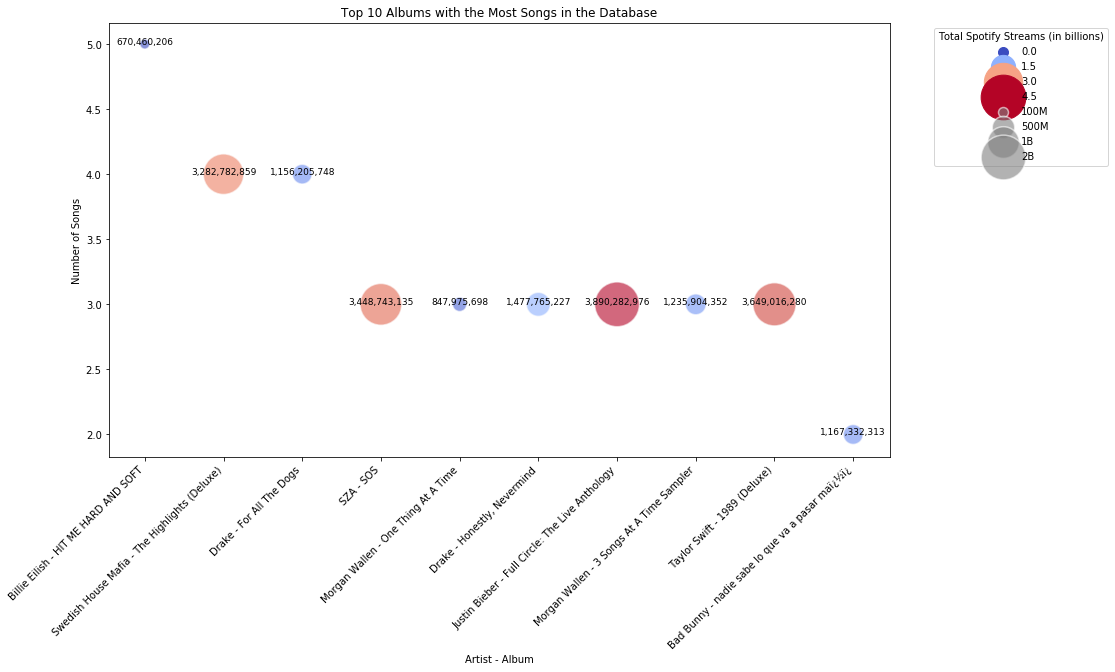

In [8]:
plt.figure(figsize=(14, 8))
bubble = sns.scatterplot(
    data=result,
    x=result['Artist'] + " - " + result['Album Name'],
    y='Number of Songs',
    size='Total Streams',
    hue='Total Streams',
    palette='coolwarm',
    sizes=(100, 2000), 
    alpha=0.6,
    edgecolor='w',
    linewidth=1.5)

plt.xlabel('Artist - Album')
plt.ylabel('Number of Songs')
plt.title('Top 10 Albums with the Most Songs in the Database')

for i in range(result.shape[0]):
    plt.text(
        x=i,
        y=result['Number of Songs'][i],
        s=f"{result['Total Streams'][i]:,.0f}",
        fontsize=9,
        ha='center')

plt.xticks(rotation=45, ha='right')

handles, labels = bubble.get_legend_handles_labels()
size_legend = [plt.scatter([], [], s=size, color='gray', alpha=0.6, edgecolor='w', linewidth=1.5) for size in [100, 500, 1000, 2000]]
labels_size = ['100M', '500M', '1B', '2B']
plt.legend(handles=handles[1:] + size_legend, labels=labels[1:] + labels_size, title='Total Spotify Streams (in billions)', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [9]:
# Question 6: What are the top 15 songs which has been released more than 10 years ago that are still trending? 
#First we need to conver the "Release date" to date time format 

df["Release Date"] = pd.to_datetime(df["Release Date"], errors='coerce')

engine = create_engine('sqlite:///:memory:', echo=False)

df.to_sql('spotify_songs', con=engine, index=False, if_exists='replace')

query = 'SELECT Track,Artist,"Release Date","Spotify Streams" FROM spotify_songs WHERE "Release Date" <= "2014-07-16" ORDER BY "Spotify Streams" DESC LIMIT 15'
df2 = pd.read_sql(query, con=engine)

print(df2)

                              Track           Artist  \
0                        Photograph       Ed Sheeran   
1                            Demons  Imagine Dragons   
2           Smells Like Teen Spirit          Nirvana   
3                       Blank Space     Taylor Swift   
4                          Payphone         Maroon 5   
5   All I Want for Christmas Is You     Mariah Carey   
6               The Real Slim Shady           Eminem   
7      Somebody That I Used To Know            Gotye   
8                 What Do You Mean?    Justin Bieber   
9              Timber (feat. Ke$ha)          Pitbull   
10               Summertime Sadness     Lana Del Rey   
11                          Animals         Maroon 5   
12    Rather Be (feat. Jess Glynne)     Clean Bandit   
13                        Heartless       Kanye West   
14                           Ho Hey    The Lumineers   

                  Release Date  Spotify Streams  
0   2013-01-01 00:00:00.000000       2525355904  
1  

In [10]:
# Question 7: Is there a connection between older songs still trending on Spotify and TikTok Posts of those songs? 
query = 'SELECT Track,Artist,"Release Date","TikTok Posts","TikTok Views" FROM spotify_songs WHERE "Release Date" <= "2014-07-16" ORDER BY "TikTok Posts" DESC LIMIT 15'
df3 = pd.read_sql(query, con=engine)

print(df3)

                              Track         Artist  \
0   All I Want for Christmas Is You   Mariah Carey   
1                        Photograph     Ed Sheeran   
2                          Firework     Katy Perry   
3     Rather Be (feat. Jess Glynne)   Clean Bandit   
4                       Promiscuous  Nelly Furtado   
5              Timber (feat. Ke$ha)        Pitbull   
6                Turn Down for What       DJ Snake   
7          I Knew You Were Trouble.   Taylor Swift   
8                Sexy And I Know It          LMFAO   
9                           Animals       Maroon 5   
10                         Worth It  Fifth Harmony   
11               Summertime Sadness   Lana Del Rey   
12                       Candy Shop        50 Cent   
13     Somebody That I Used To Know          Gotye   
14              Young And Beautiful   Lana Del Rey   

                  Release Date  TikTok Posts  TikTok Views  
0   1994-01-01 00:00:00.000000    18894720.0  1.596313e+10  
1   2013-01-0

In [11]:
common_tracks = pd.merge(df2, df3, on='Track', suffixes=('Spotify', 'TikTok'))
print(common_tracks[['Track']])
# When combining queries 6&7, there seems to be a correlation between the two. 7 out of 15 (46%!) "not so new songs" that are still trending in 2024 are also in the list of the most trending 10 year old+ songs on TikTok.

                             Track
0                       Photograph
1  All I Want for Christmas Is You
2     Somebody That I Used To Know
3             Timber (feat. Ke$ha)
4               Summertime Sadness
5                          Animals
6    Rather Be (feat. Jess Glynne)


In [12]:
#To verify our findings, I ran the same queries in different limits of operation (25 songs and 50 songs) to see if the results show the same upward trend
#25 songs
query = 'SELECT Track,Artist,"Release Date","Spotify Streams" FROM spotify_songs WHERE "Release Date" <= "2014-07-16" ORDER BY "Spotify Streams" DESC LIMIT 25'
df2 = pd.read_sql(query, con=engine)
query = 'SELECT Track,Artist,"Release Date","TikTok Posts","TikTok Views" FROM spotify_songs WHERE "Release Date" <= "2014-07-16" ORDER BY "TikTok Posts" DESC LIMIT 25'
df3 = pd.read_sql(query, con=engine)
common_tracks = pd.merge(df2, df3, on='Track')
print(common_tracks[['Track']])
#The correlation is sligtly increased to 13/25 (52%), findings that can verify the connection between the two.

                              Track
0                        Photograph
1                            Demons
2           Smells Like Teen Spirit
3   All I Want for Christmas Is You
4      Somebody That I Used To Know
5              Timber (feat. Ke$ha)
6                Summertime Sadness
7                           Animals
8     Rather Be (feat. Jess Glynne)
9               Young And Beautiful
10                      Promiscuous
11                         Firework
12                            Latch


In [13]:
#50 songs
query = 'SELECT Track,Artist,"Release Date","Spotify Streams" FROM spotify_songs WHERE "Release Date" <= "2014-07-16" ORDER BY "Spotify Streams" DESC LIMIT 50'
df2 = pd.read_sql(query, con=engine)
query = 'SELECT Track,Artist,"Release Date","TikTok Posts","TikTok Views" FROM spotify_songs WHERE "Release Date" <= "2014-07-16" ORDER BY "TikTok Posts" DESC LIMIT 50'
df3 = pd.read_sql(query, con=engine)
common_tracks = pd.merge(df2, df3, on='Track')
print(common_tracks[['Track']])
#The correlation drasticly climbed to 48/50 (96%), confirming the first assumption on the association and proving there is a strong linear correspondence between the two categories.
#From the last queries we can safely deduce that an enhanced exposure to songs on one of the social media platforms (in this case TikTok) can influence the ratings of the track in other platforms.

                              Track
0                        Photograph
1                            Demons
2           Smells Like Teen Spirit
3                       Blank Space
4                          Payphone
5   All I Want for Christmas Is You
6               The Real Slim Shady
7      Somebody That I Used To Know
8                 What Do You Mean?
9              Timber (feat. Ke$ha)
10               Summertime Sadness
11                          Animals
12    Rather Be (feat. Jess Glynne)
13                        Heartless
14                           Ho Hey
15              Young And Beautiful
16                           Royals
17                            Style
18                        Let It Go
19                      Promiscuous
20                         Firework
21                       Just Dance
22                            Latch
23                    We Can't Stop
24         You're Gonna Go Far, Kid
25                       Am I Wrong
26                       Can

In [14]:
# Question 8: What are the top 15 "Shazamed" tracks? 
query = 'SELECT Track,Artist,"Shazam Counts" FROM spotify_songs ORDER BY "Shazam Counts" DESC LIMIT 15'
df4 = pd.read_sql(query, con=engine)

print(df4)

                                      Track           Artist  Shazam Counts
0                              Dance Monkey      Tones And I     44842636.0
1              Somebody That I Used To Know            Gotye     37339828.0
2                           Blinding Lights       The Weeknd     28994660.0
3                                     Faded      Alan Walker     26821494.0
4             Rather Be (feat. Jess Glynne)     Clean Bandit     25620314.0
5   Rockabye (feat. Sean Paul & Anne-Marie)     Clean Bandit     23696980.0
6                                 Calm Down             Rema     22563407.0
7                                  Believer  Imagine Dragons     21306706.0
8                                Am I Wrong      Nico & Vinz     19231875.0
9                         Sign of the Times     Harry Styles     18327076.0
10                                   Demons  Imagine Dragons     18161724.0
11                                   Ho Hey    The Lumineers     17971225.0
12          

In [15]:
# After Comparison with the results of query #1 we have 6/15 (40%) of the most "Shazamed" songs in the top 15 tracks with max spotify streams.
shazamed_tracks = pd.merge(df1, df4, on='Track')
print(shazamed_tracks[['Track']])

             Track
0  Blinding Lights
1     Dance Monkey
2         Believer
3       Photograph
4        The Hills
5           Demons


In [16]:
#25 songs
query = 'SELECT Track,Artist,"Shazam Counts" FROM spotify_songs ORDER BY "Shazam Counts" DESC LIMIT 25'
df4 = pd.read_sql(query, con=engine)
shazamed_tracks = pd.merge(df1, df4, on='Track', suffixes=('Spotify', 'Shazam'))
print(shazamed_tracks[['Track']])
# From expanding the borders of the query,we can verify the incline not only haven't been linearly growing(now only 7/25 songs 28%) but took quiet a descent.
# So in terms of trends, trending songs are not the ones with the most Shazam counts, even when they're the most heard.
# For me the result comes as counter intuitive, because my assumption was that more trending songs will be the most "Shazamed" ones, priorly due to the previous query about the TikTok trending old songs being proved with a strong correlation.

             Track
0  Blinding Lights
1          Starboy
2     Dance Monkey
3         Believer
4       Photograph
5        The Hills
6           Demons


In [17]:
# Question 9: List all the Streaming platforms according to their total streams 
query = '''SELECT
'Spotify Streams' AS Platform, SUM("Spotify Streams") AS TotalStreams
FROM spotify_songs
UNION
SELECT 
    'Youtube Views' AS Platform, SUM("Youtube Views") AS TotalStreams 
FROM spotify_songs
UNION
SELECT 
    'AirPlay Spins' AS Platform, SUM("AirPlay Spins") AS TotalStreams 
FROM spotify_songs
UNION
SELECT 
    'SiriusXM Spins' AS Platform, SUM("SiriusXM Spins") AS TotalStreams 
FROM spotify_songs
UNION
SELECT 
    'Pandora Streams' AS Platform, SUM("Pandora Streams") AS TotalStreams 
FROM spotify_songs
UNION
SELECT 
    'Soundcloud Streams' AS Platform, SUM("Soundcloud Streams") AS TotalStreams 
FROM spotify_songs
ORDER BY TotalStreams DESC '''
result = pd.read_sql(query, con=engine)

print(result)

             Platform  TotalStreams
0     Spotify Streams  4.055003e+11
1       Youtube Views  2.500757e+11
2     Pandora Streams  7.238921e+10
3  Soundcloud Streams  9.982222e+09
4       AirPlay Spins  5.971326e+07
5      SiriusXM Spins  1.866190e+05


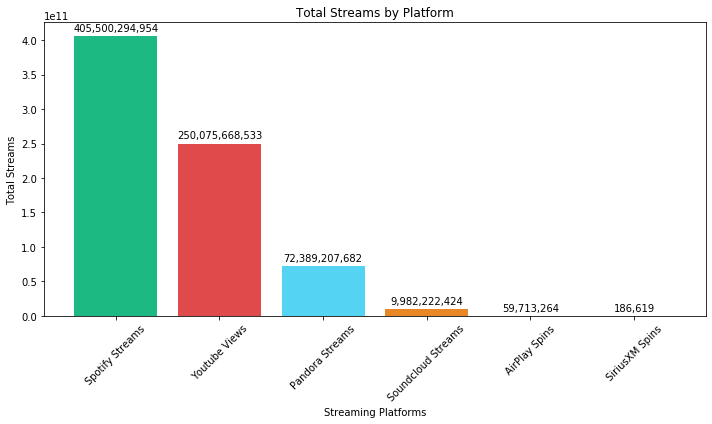

In [18]:
result['TotalStreams'] = result['TotalStreams'].astype(float)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(result['Platform'], result['TotalStreams'], color=['#1db982', '#e04a4a', '#55d3f2', '#e88725', '#415ff2', '#edaf51', '#943872'])

ax.set_xlabel('Streaming Platforms')
ax.set_ylabel('Total Streams')
ax.set_title('Total Streams by Platform')

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:,.0f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.xticks(rotation='45')
plt.tight_layout()

plt.show()

In [19]:
# Question 10: Top 15 Songs in all of the platforms combined
query = '''SELECT 
    Track,Artist,("Spotify Streams" + "Youtube Views" + "AirPlay Spins" + "Sirius XM Spins" + 
     "Pandora Streams" + "Soundcloud Streams") AS Total_Streams
FROM (SELECT * FROM spotify_songs ORDER BY ("Spotify Streams" + "Youtube Views" + "AirPlay Spins" + 
     "Sirius XM Spins" + "Pandora Streams" + "Soundcloud Streams") DESC LIMIT 15)
'''

#query = '''SELECT 
    #Track,Artist,("Spotify Streams" + "Youtube Views" + "AirPlay Spins" + "Sirius XM Spins" + 
     #"Pandora Streams" + "Soundcloud Streams") AS Total_Streams
#FROM (SELECT * FROM spotify_songs ORDER BY ("Spotify Streams" + "Youtube Views" + "AirPlay Spins" + 
     #"Sirius XM Spins" + "Pandora Streams" + "Soundcloud Streams") DESC LIMIT 50)
#'''
#query = '''SELECT 
    #Track,Artist,("Spotify Streams" + "Youtube Views" + "AirPlay Spins" + "Sirius XM Spins" + 
     #"Pandora Streams" + "Soundcloud Streams") AS Total_Streams
#FROM (SELECT * FROM spotify_songs ORDER BY ("Spotify Streams" + "Youtube Views" + "AirPlay Spins" + 
     #"Sirius XM Spins" + "Pandora Streams" + "Soundcloud Streams") DESC LIMIT 100)
#'''
#The above queries are for the final conclusion statistics.
df5 = pd.read_sql(query, con=engine)

print(df5)

                                      Track           Artist  Total_Streams
0                              Shape of You       Ed Sheeran   1.273557e+10
1                                  Believer  Imagine Dragons   8.119063e+09
2                                     Sorry    Justin Bieber   6.977790e+09
3                              Dance Monkey      Tones And I   6.848960e+09
4                                   Starboy       The Weeknd   6.476229e+09
5                               Blank Space     Taylor Swift   6.186008e+09
6                           Blinding Lights       The Weeknd   5.634930e+09
7                                   Shallow        Lady Gaga   5.568815e+09
8                 This Is What You Came For    Calvin Harris   5.428080e+09
9                                 The Hills       The Weeknd   5.399778e+09
10             Somebody That I Used To Know            Gotye   5.376221e+09
11                                   Demons  Imagine Dragons   5.123728e+09
12  Rockabye

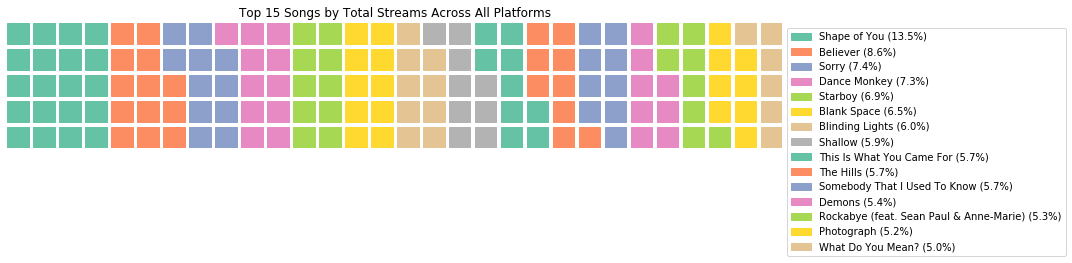

In [20]:
from pywaffle import Waffle
fig = plt.figure(
    FigureClass=Waffle,
    rows=5,  
    columns=30,  
    values=df5.set_index('Track')['Total_Streams'],
    labels=["{} ({:.1f}%)".format(k, v * 100 / df5['Total_Streams'].sum()) for k, v in df5.set_index('Track')['Total_Streams'].items()],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    title={'label': 'Top 15 Songs by Total Streams Across All Platforms', 'loc': 'center'},
    figsize=(15, 8)
)

plt.show()

In [21]:
most_heard_tracks = pd.merge(df1, df5, on='Track')
print(most_heard_tracks[['Track','Total_Streams']])
#10/15(66%) track relation between spotify and all time most heard songs. When we're expending the search for 50 songs limit, the correlation goes up to 74%. When the expansion goes to 100 tracks, the correlation still on 74%. 
#The conclusion: The most trending tracks on Spotify have a nearly 3/4 chance to be the most trending track in all of the platforms.

             Track  Total_Streams
0  Blinding Lights   5.634930e+09
1     Shape of You   1.273557e+10
2          Starboy   6.476229e+09
3     Dance Monkey   6.848960e+09
4         Believer   8.119063e+09
5       Photograph   4.896791e+09
6          Shallow   5.568815e+09
7        The Hills   5.399778e+09
8           Demons   5.123728e+09
9            Sorry   6.977790e+09
